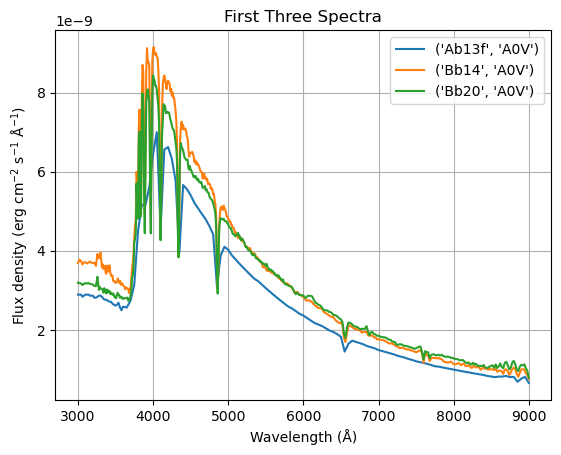

In [66]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.io import fits
import pandas as pd


# Read the spectra_list
spectra_list = Table.read(fr"C:\Users\damia\Documents\GitHub\ALOP-PROBLEM-1\spectra_list.csv", format ="ascii.csv")


filenames = spectra_list['filename']
types = spectra_list['type']



spectra = [Table.read(fr"C:\Users\damia\Documents\GitHub\ALOP-PROBLEM-1\spectra\{filename}", format ="ascii.csv") for filename in filenames]


wavelengths_list = [data['wavelength'] for data in spectra]
fluxes_list = [data['flux'] for data in spectra]


# Loop through 
indices = np.linspace(0, len(filenames) - 1, 3, dtype=int)
#for i in indices:
for i in range(3):
    # Filter data where wavelength is between 3000 and 9000
    mask = (wavelengths_list[i] >= 3000) & (wavelengths_list[i] <= 9000)
    plt.plot(wavelengths_list[i][mask], fluxes_list[i][mask], label=(os.path.splitext(filenames[i])[0], types[i]))

# Adding labels and title
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux density (erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)')
plt.title('First Three Spectra')
plt.legend()  
plt.grid(True)

plt.savefig('First_Three_Spectra1.pdf', format='pdf')

# Show the plot
plt.show()

In [ ]:
# Problem 2

print('An angstrom is 10^-10 m')
print('A unit is W/m^2 or a jansky.')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


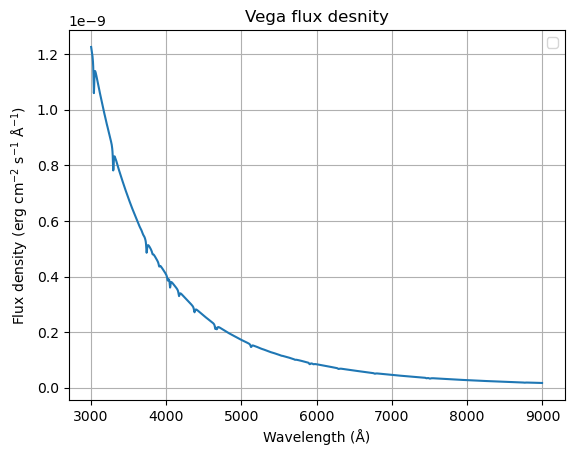

In [82]:
# Problem 3

#data = fits.getdata("file.fits")



vega_path = fr'C:\Users\damia\Documents\GitHub\ALOP-PROBLEM-1\vega_fnu.csv'
#Notice: For this spectrum, the wavelength is given in nanometers and the flux density in erg cm-2 s-1 Hz-1.

def convert_flux_density(flux_vega, wavelength ):
    """Convert from erg cm^-2 s^-1 Hz^-1 to erg cm^-2 s^-1 Å^-1"""
    return flux_vega * (3e18 / wavelength**2)

def calculate_magnitude(star_flux, vega_flux):
    """Calculate the magnitude in a band."""
    return -2.5 * np.log10(star_flux / vega_flux)


vega_spectrum = Table.read(vega_path, format ="ascii.csv") 

vega_wavelength = vega_spectrum['wavelength'] 
vega_flux_density = vega_spectrum['flux'] 

vega_converted_flux_density = convert_flux_density(vega_flux_density, vega_wavelength)


# Filter data where wavelength is between 3000 and 9000
mask = (vega_wavelength >= 3000) & (vega_wavelength <= 9000)
plt.plot(vega_wavelength[mask], vega_converted_flux_density[mask])

# Adding labels and title
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux density (erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)')
plt.title('Vega flux desnity')
plt.legend()  
plt.grid(True)




# Show the plot
plt.show()

# We see vega lines up decently with what we expect

# Now we need to integrate the flux density with the correct bounds for the different filters.
# U, B, V bands
filters = {
    'U': {'lambda_0': 3659, 'delta_lambda': 660, 'color': 'violet'},
    'B': {'lambda_0': 4582, 'delta_lambda': 940, 'color': 'blue' },
    'V': {'lambda_0': 5448, 'delta_lambda': 880, 'color': 'green'}
}


# Placeholder for the dictionary to store magnitudes
stars_data = {filename: {} for filename in filenames}

# Loop through each star

# Before we can use this, we must see that the steps are too large for these bounds. The steps between our measurements are 20, so we would first like to interpolatre this to get a more continious function.
for filename, star_type, wavelength, flux_density in zip(filenames,types, wavelengths_list, fluxes_list):
    star_magnitudes = {}
    
    for band, filter_data in filters.items():
        lambda_min = filter_data['lambda_0'] - filter_data['delta_lambda'] / 2
        lambda_max = filter_data['lambda_0'] + filter_data['delta_lambda'] / 2

        # Interpolate the flux within the B-band range
        band_wavelengths = np.linspace(lambda_min, lambda_max, 100)
        band_flux_density = np.interp(band_wavelengths, wavelength, flux_density)

        #plt.plot(band_wavelengths, band_flux_density, label=band, color=filter_data['color'])

        # Integrate flux over the wavelength range
        star_flux_integrated = np.trapz(band_flux_density, band_wavelengths)
        vega_flux_integrated = np.trapz(vega_converted_flux_density, vega_wavelength)
        #print(star_flux_integrated, vega_flux_integrated)
        # Calculate magnitude
        magnitude = calculate_magnitude(star_flux_integrated, vega_flux_integrated)
        #print(f"{band}-band magnitude: {magnitude}")
        star_magnitudes[band] = magnitude

    # Store magnitudes in the dictionary
    stars_data[filename] = star_magnitudes



In [84]:


df = pd.DataFrame.from_dict(stars_data, orient='index')

df['type'] = types
# Calculate U-B and B-V
df['U-B'] = df['U'] - df['B']
df['B-V'] = df['B'] - df['V']


# Reorder columns to put 'type' first
columns_order = ['type', 'U', 'B', 'V', 'U-B', 'B-V']
df = df[columns_order]

print(df)

          type         U         B         V       U-B       B-V
Ab13f.csv  A0V  5.291178  4.535210  5.094910  0.755969 -0.559700
Bb14.csv   A0V  5.004819  4.293074  4.911276  0.711744 -0.618202
Bb20.csv   A0V  5.120706  4.367289  4.912367  0.753417 -0.545079
Ab14f.csv  A1V  5.707917  4.941981  5.494817  0.765936 -0.552836
Bb17.csv   A1V  5.042128  4.312449  4.907101  0.729680 -0.594653
...        ...       ...       ...       ...       ...       ...
Ab64f.csv  O7I -2.950514 -2.558831 -1.802807 -0.391683 -0.756024
Ab2f.csv   O7V -2.458473 -1.988690 -1.204067 -0.469783 -0.784623
Ab3f.csv   O8V -1.834280 -1.383356 -0.603430 -0.450924 -0.779927
Ab65f.csv  O9I -2.951233 -2.560310 -1.803202 -0.390923 -0.757108
Ab4f.csv   O9V -1.600494 -1.199265 -0.402266 -0.401230 -0.796999

[92 rows x 6 columns]


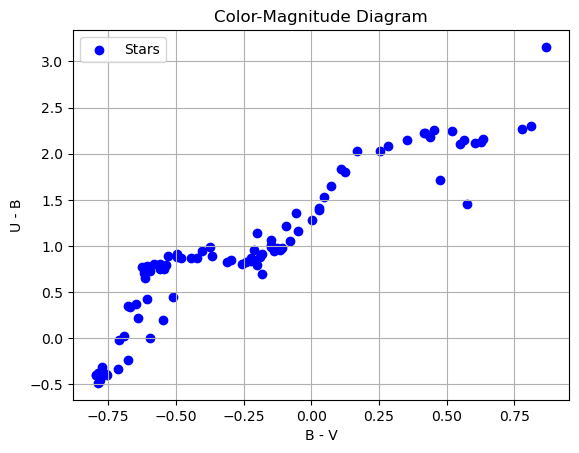

In [89]:
plt.scatter(df['B-V'], df['U-B'], c='blue', label='Stars')
plt.ylabel('U - B')
plt.xlabel('B - V')
plt.title('Color-Magnitude Diagram')
plt.grid(True)
plt.legend()
plt.show()

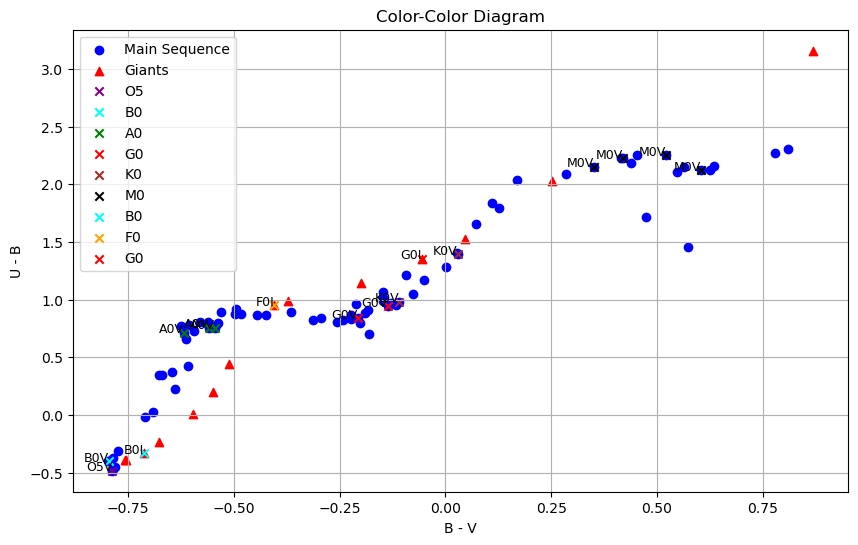

In [109]:


# Filter data by type
main_sequence = df[df['type'].str.contains("V")]
giants = df[df['type'].str.contains("I")]

spectral_types = ["O5", "B0", "A0", "F0", "G0", "K0", "M0"]

# Function to plot and label specific spectral types
def plot_spectral_types(df, spectral_types, color_dict):
    for spec_type in spectral_types:
        # Filter stars of this spectral type
        stars = df[df['type'].str.contains(spec_type)]
        if not stars.empty:
            # Plot the spectral type
            plt.scatter(stars['B-V'], stars['U-B'], label=f'{spec_type}', color=color_dict.get(spec_type, 'black'), marker='x')
            # Optionally add text labels for these stars
            for index, row in stars.iterrows():
                plt.text(row['B-V'], row['U-B'], row['type'], fontsize=9, ha='right', color='black')

# Color dictionary for spectral types
color_dict = {
    "O5": 'purple',
    "B0": 'cyan',
    "A0": 'green',
    "F0": 'orange',
    "G0": 'red',
    "K0": 'brown',
    "M0": 'black'
}


# Plot U-B vs B-V
plt.figure(figsize=(10, 6))

# Plot Main Sequence Stars
plt.scatter(main_sequence['B-V'], main_sequence['U-B'], label='Main Sequence', c='blue', marker='o')

# Plot Giants
plt.scatter(giants['B-V'], giants['U-B'], label='Giants', c='red', marker='^')

# Plot and label specific spectral types
plot_spectral_types(main_sequence, spectral_types, color_dict)
plot_spectral_types(giants, spectral_types, color_dict)

# Add labels and legend
plt.xlabel('B - V')
plt.ylabel('U - B')
plt.title('Color-Color Diagram')
plt.legend()
plt.grid(True) 
plt.show()


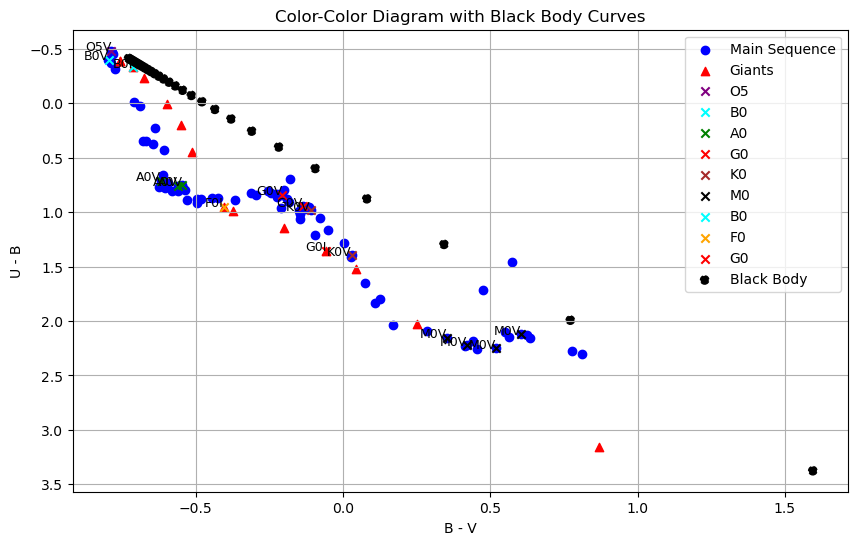

In [115]:
from astropy.constants import c, h, k_B
import numpy as np
import scipy.integrate as integrate

def blackbody_flux(wavelength, temperature):
    """Calculate blackbody flux at a given wavelength and temperature."""
    # Convert wavelength from Ångströms to meters
    wavelength_m = wavelength * 1e-10
    # Calculate the exponent for Planck's law (dimensionless)
    exponent = (h.value * c.value) / (wavelength_m * k_B.value * temperature)
    # Planck's law formula
    flux = (2 * h.value * c.value**2) / (wavelength_m**5 * (np.exp(exponent) - 1))
    return flux

def integrate_band_flux(wavelengths, flux_density):
    """Integrate the flux density over the given wavelength range."""
    return np.trapz(flux_density, wavelengths)

def calculate_blackbody_magnitude(temperature, band):
    """Calculate the magnitude for a black body in a given band."""
    # Define the band limits
    lambda_min = filters[band]['lambda_0'] - filters[band]['delta_lambda'] / 2
    lambda_max = filters[band]['lambda_0'] + filters[band]['delta_lambda'] / 2
    band_wavelengths = np.linspace(lambda_min, lambda_max, 100)
    # Calculate blackbody flux density
    band_flux_density = blackbody_flux(band_wavelengths, temperature)
    # Integrate the flux over the band range
    integrated_flux = integrate_band_flux(band_wavelengths, band_flux_density)
    # Calculate the magnitude
    return -2.5 * np.log10(integrated_flux / np.trapz(vega_converted_flux_density, vega_wavelength))

# Define temperature range
temperatures = np.arange(2000, 31000, 1000)  # From 2000 K to 30000 K

# Calculate U-B and B-V colors for black bodies
blackbody_colors = {'T': [], 'U-B': [], 'B-V': []}

for temp in temperatures:
    U_mag = calculate_blackbody_magnitude(temp, 'U')
    B_mag = calculate_blackbody_magnitude(temp, 'B')
    V_mag = calculate_blackbody_magnitude(temp, 'V')
    
    U_B = U_mag - B_mag
    B_V = B_mag - V_mag
    
    blackbody_colors['T'].append(temp)
    blackbody_colors['U-B'].append(U_B)
    blackbody_colors['B-V'].append(B_V)

# Plot U-B vs B-V
plt.figure(figsize=(10, 6))

# Plot Main Sequence Stars
plt.scatter(main_sequence['B-V'], main_sequence['U-B'], label='Main Sequence', c='blue', marker='o')

# Plot Giants
plt.scatter(giants['B-V'], giants['U-B'], label='Giants', c='red', marker='^')

# Plot and label specific spectral types
plot_spectral_types(main_sequence, spectral_types, color_dict)
plot_spectral_types(giants, spectral_types, color_dict)

# Plot black body curves
plt.scatter(blackbody_colors['B-V'], blackbody_colors['U-B'], color='black', linestyle='--', label='Black Body')

# Add labels and legend
plt.xlabel('B - V')
plt.ylabel('U - B')
plt.title('Color-Color Diagram with Black Body Curves')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis()  # Invert the y-axis to match typical color-color diagrams
plt.show()
